In [1]:
import torchbnn as bnn
import torch
import torch.nn.functional as F
from torch import nn
from torch.optim import Adam

import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import training_utils as utils

%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device("cpu")

In [18]:
train_loader, test_data = utils.get_nanotube_data()
X_test, Y_test = test_data
lr_start = 0.001

model = nn.Sequential(
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=7, out_features=30),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=30, out_features=20),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=20, out_features=1),
)

optimizer = Adam(model.parameters(), lr=lr_start)

In [12]:
def train_model(model, optimizer, train_loader, device, num_epochs=30):
    mse = nn.MSELoss()
    kl = bnn.BKLLoss(reduction="mean", last_layer_only=False)
    weight = 0.01

    pbar = tqdm(range(num_epochs))
    for i in pbar:
        for bi, (x, y) in enumerate(train_loader):
            x, y = x.to(device), y.to(device)
            out = model(x)

        
            loss = mse(out, y) + weight * kl(model)
            loss.backward()
            optimizer.step()
        pbar.set_description(f"{loss.data[0]}")

In [19]:
train_model(model, optimizer, train_loader, device)

7.12135124206543: 100%|██████████| 30/30 [03:28<00:00,  6.95s/it]  


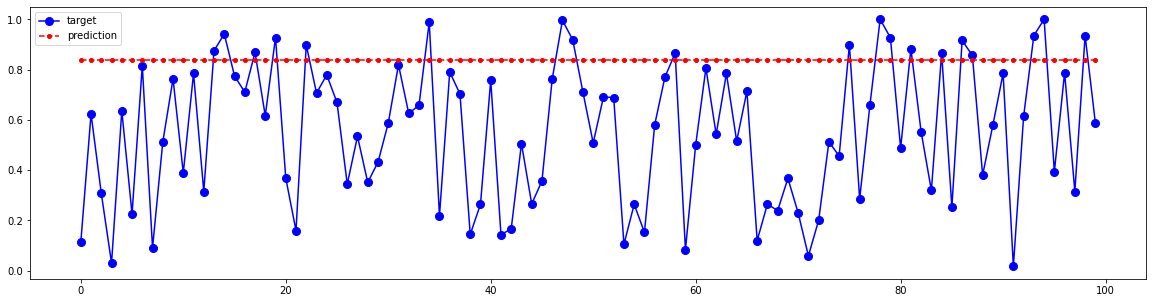

In [20]:
plt.rcParams["figure.figsize"] = (20,5)
def plot_model_pred(model, Y_test, X_test):
    Y_sample = Y_test.detach().numpy()[:100]
    Y_pred_sample = model(X_test).detach().numpy()[:100]
    plt.plot(Y_sample, "bo-", ms=8, label="target")
    plt.plot(Y_pred_sample, "ro--", ms=4, label="prediction")
    plt.legend()
    plt.show()
plot_model_pred(model, Y_test, X_test)